# Projet Classifier automatiquement des biens de consommation : Notebook de prétraitement et feature extraction

In [1]:
# Importation des librairies nécessaires

import os, sys, time, random, pickle

# Data
import pandas as pd
import numpy as np

# NLP
!pip install nltk
!pip install wordcloud
!pip install tweepy
!pip install textblob
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.tokenize import RegexpTokenizer
import re
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

!pip install spacy
import spacy

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image, ImageFilter, ImageOps
from skimage import exposure, img_as_ubyte

import plotly.express as px
import plotly.graph_objects as go

!pip install pandarallel
from pandarallel import pandarallel        #Pour exécuter des codes non pass sur un seul CPU mais sur l'ensemble des CPU de notre ordinateur

!pip install contractions
%time
import contractions

OMP_NUM_THREADS=5

CPU times: total: 0 ns
Wall time: 0 ns


In [2]:
pd.options.display.max_colwidth = 200

In [3]:
# download

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tykap\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tykap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tykap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\tykap\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tykap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# pandarallel
pandarallel.initialize(progress_bar=True,
                       nb_workers=6,
                       verbose=1)

In [5]:
# Init sns
sns.set()

In [6]:
# Chargement des données

data = "./Flipkart/"
os.listdir(data)

['flipkart_com-ecommerce_sample_1050.csv']

In [7]:
# Chargement des données
fn = data + 'flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(fn)
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                                                                                                       product_url  \
0       http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
1                                       http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2                              http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3  http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4   
4            http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v?pid=BDSEJTHNGWVGWWQU   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                                                       product_category_tree  \
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]   
2   ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]   
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]   
4             ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   
3  BDSEJT9UQWHDUBH4        2699.0            1299.0   
4  BDSEJTHNGWVGWWQU        2599.0             698.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                                                                                                                                                                               description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Euro

In [8]:
# Observons un échantillon aléatoire
df.sample(20)

uniq_id            crawl_timestamp  \
95    f4d4c2eec77732f56e47722d7a355f2b  2016-01-04 00:20:04 +0000   
422   0e1e3861d54a8a17b7b91f04071a4ca3  2016-06-17 07:53:02 +0000   
147   f8794f7a06b530782c66f7c0911bb437  2015-12-01 12:40:44 +0000   
513   93f01d6cd167fa549928a9b649f87ccc  2016-01-07 05:50:25 +0000   
686   911a6efe69bde398fbbddcb0b4bb466f  2015-12-31 09:19:31 +0000   
534   4019ad332ca3ce22449ff54fdd49a273  2016-01-07 05:50:25 +0000   
743   d47f1cb78db4a23e2516e2d34da34c8a  2015-12-12 11:46:53 +0000   
125   7241df1acae1fac892c692097ea3fb98  2015-12-01 12:40:44 +0000   
994   fc8ff72b68b0f3736a9aff8f03aa712f  2016-03-23 04:17:35 +0000   
28    b52073e7ed9c00c4108cae4eb0c49c1a  2015-12-04 07:25:36 +0000   
313   6c8f99e979d4de9ab5d1ad20455622c7  2015-12-01 06:13:00 +0000   
464   c063d07d78a55a21bf6c0e7c8ae46a6d  2016-03-22 19:59:16 +0000   
1004  6325bf868b9040a0599f257aba42e9e0  2016-03-03 11:29:08 +0000   
914   762b6b22cccf91935e92446efe298fe3  2016-04-02 19:26:28 +0000   
746   037c2402fee39fbc80433935711d1383  2015-12-12 11:46:53 +0000   
597   30ab693b54e99a469a1152b5db14aa40  2016-03-21 12:00:58 +0000   
940   9c9385abdb73ec1f1f93acaf81c6e1d7  2016-01-01 13:15:34 +0000   
396   387ecd9ec173d61b6dc5ceddc079b150  2015-12-01 06:13:00 +0000   
395   862c7462f12de819d93f93dc573289c5  2015-12-01 06:13:00 +0000   
822   3fd4d7ea04624ada39fde3957c7b9b7c  2016-05-08 09:23:06 +0000   

                                                                                                                                   product_url  \
95                             http://www.flipkart.com/exotic-india-blessing-buddha-showpiece-36-83-cm/p/itme3qdgysexzzvq?pid=SHIE3QDGUEGVZJZ8   
422   http://www.flipkart.com/clear-face-kesar-chandan-multivitamin-nourishing-skin-cream-almond-honey/p/itmegsg7r6zzzgpt?pid=CBKEGSG7XXSCTME7   
147                             http://www.flipkart.com/rockmantra-fantasy-artrmmw50000330-ceramic-mug/p/itmeaggkbkcgscuu?pid=MUGEAGGKMRZABCNZ   
513                                   http://www.flipkart.com/global-nomad-gnlbbl0314-analog-watch-men/p/itmdzrzkqqzc66en?pid=WATDZRZGCSSQ8RYS   
686          http://www.flipkart.com/keya-seth-umbrella-protex-heat-proof-sunscreen-solution-spf-75-pa/p/itmecf6uusfgdzfb?pid=SNRECF6UH7GERGGU   
534                                        http://www.flipkart.com/timewel-1100-n1685-analog-watch-men/p/itmeyap3rr3fw39g?pid=WATEYAP32BAUMHMD   
743                        http://www.flipkart.com/nutcase-sticker-wrap-design-pineapple-800-ml-bottle/p/itmeanchfwn5htnz?pid=BOTEANCH6ZZZHJVD   
125                          http://www.flipkart.com/sally-hansen-la-cross-5-pcs-festival-grooming-kit/p/itmdszqssfsmkr3q?pid=MNKDSZQR3NAMFTDQ   
994                                              http://www.flipkart.com/am-creation-magic-ceramic-mug/p/itmeh2zhpxmurjzd?pid=MUGEH2ZHFHQZSGQG   
28                  http://www.flipkart.com/vizion-8502-7purple-sports-series-digital-watch-boys-girls/p/itmecsw5ykywn7ug?pid=WATECSW5DJ3UBZYT   
313                                   http://www.flipkart.com/adidas-ice-drive-dynamic-pulse-combo-set/p/itme6hyjfrby89yv?pid=CAGE6HYJPDEM4AN3   
464                                   http://www.flipkart.com/fs-mini-klub-baby-girl-s-fit-flare-dress/p/itmegxz28tamwurs?pid=DREEGXZ2QN5ZKDGH   
1004                http://www.flipkart.com/doraemon-gift-family-ceramic-coffee-mug-multicolour-325-ml/p/itmeg7k7fe48hpgh?pid=DECEG7K7Y3URGWXH   
914                               http://www.flipkart.com/612-league-baby-boy-s-checkered-casual-shirt/p/itmefgcee4r3wbcz?pid=SHTEFGCEGSYJT3MN   
746                                          http://www.flipkart.com/ecraftindia-floral-cushions-cover/p/itme69jgbazdagb5?pid=CPCE69JGZ42PXPWV   
597                               http://www.flipkart.com/little-feetz-baby-girl-s-solid-top-skirt-set/p/itmehya7pkemh3qm?pid=NSTEHYA7NGZJ6Z5B   
940                                        http://www.flipkart.com/digilight-200-inch-blue-rice-lig

In [9]:
df.shape

(1050, 15)

In [10]:
df.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [12]:
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

'''Nous observons qu'il y a 1050 valeurs uniques pour uniq_id pour 1050 descriptions uniques des produits. Nous n'avons à priori par de doublon c'est à dire plusieurs produits 
ayant la même description.'''

In [13]:
df.isna().mean().sort_values()

uniq_id                    0.000000
crawl_timestamp            0.000000
product_url                0.000000
product_name               0.000000
product_category_tree      0.000000
pid                        0.000000
image                      0.000000
is_FK_Advantage_product    0.000000
description                0.000000
product_rating             0.000000
overall_rating             0.000000
retail_price               0.000952
discounted_price           0.000952
product_specifications     0.000952
brand                      0.321905
dtype: float64

<Axes: >

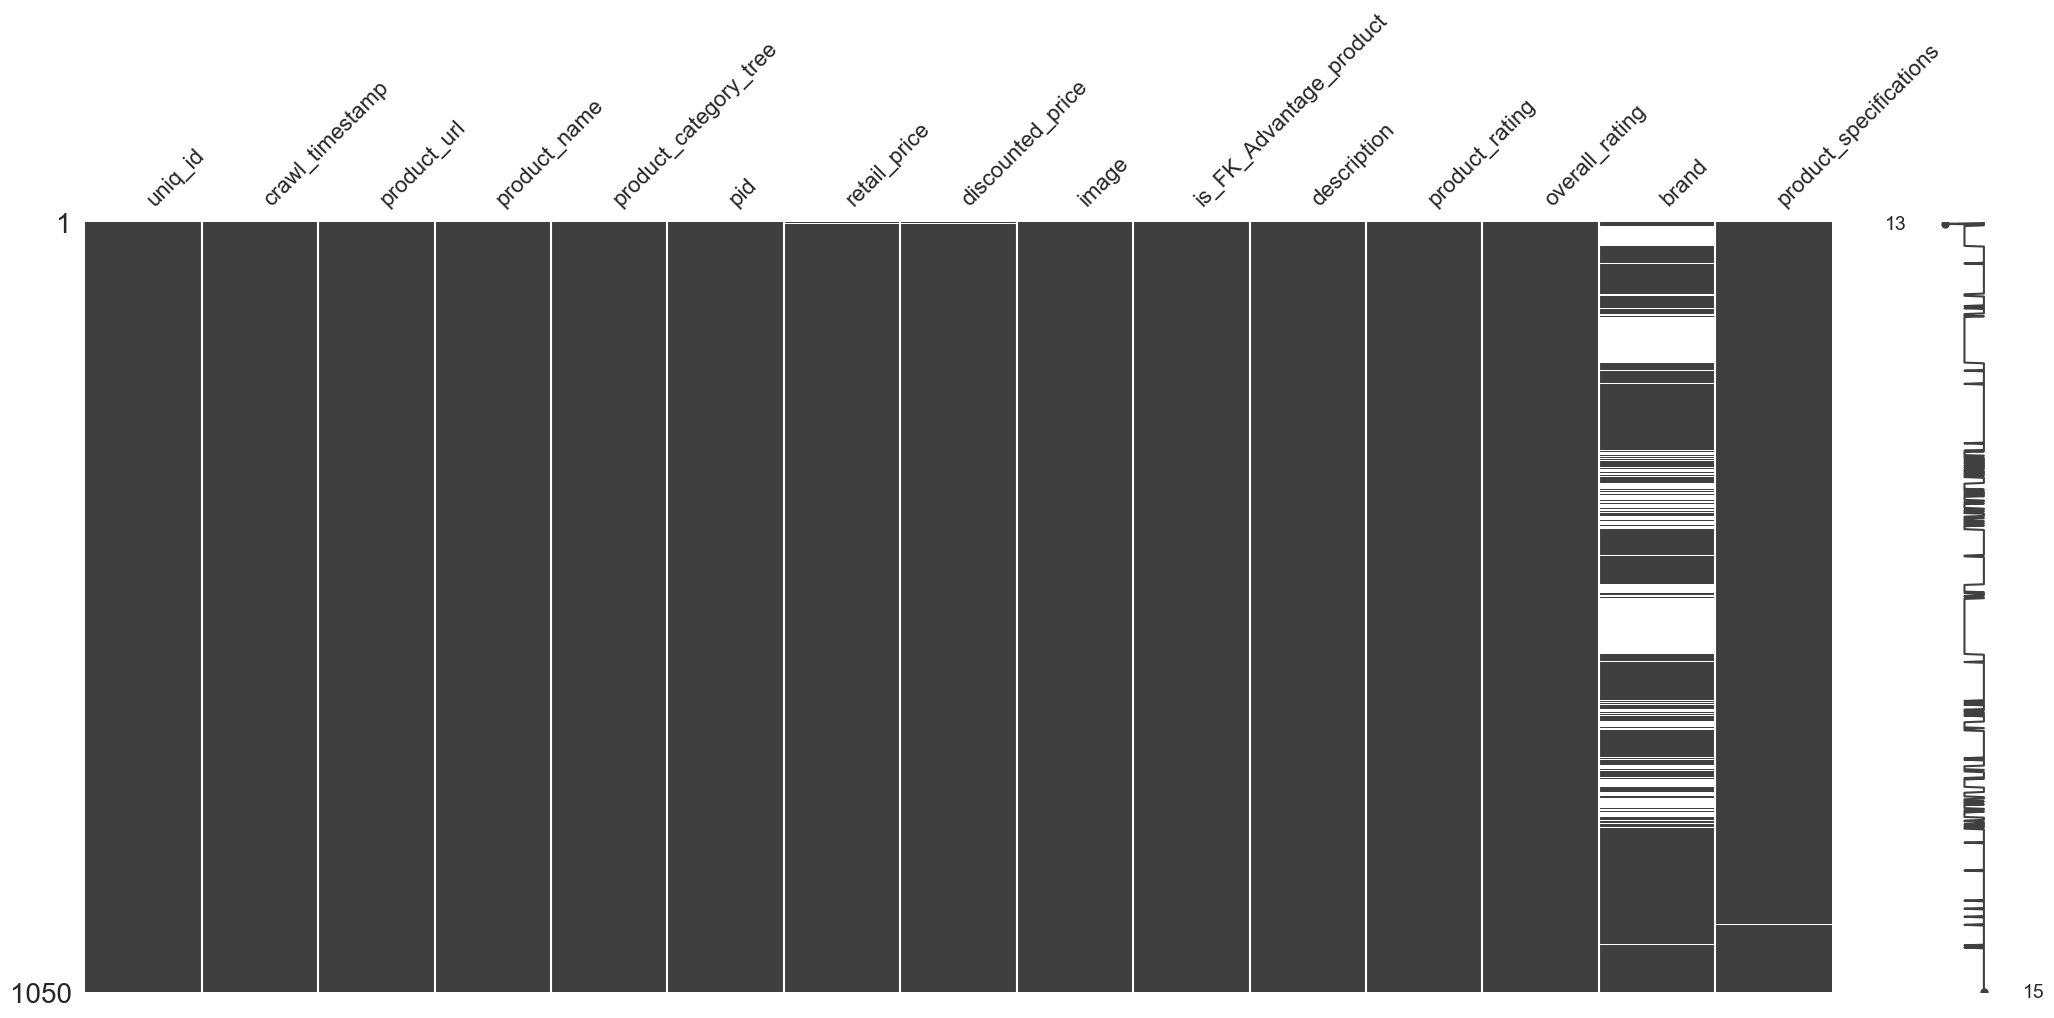

In [14]:
import missingno as msno

msno.matrix(df)

Nous n'avons pas de données manquantes sur les variables qui nous sont utiles pour nos analyses "uniq_id", "product_category_tree", "image" et "description".

In [15]:
df.duplicated().sum()

0

In [16]:
df.duplicated(subset="description").sum()

0

In [17]:
df.describe(include=object)

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   

                                                                                                                       product_url  \
count                                                                                                                         1050   
unique                                                                                                                        1050   
top     http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
freq                                                                                                                             1   

                                                      product_name  \
count                                                         1050   
unique                                                        1050   
top     Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
freq                                                             1   

                                                product_category_tree  \
count                                                            1050   
unique                                                            642   
top     ["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]   
freq                                                               56   

                     pid                                 image  \
count               1050                                  1050   
unique              1050                                  1050   
top     CRNEG7BKMFFYHQ8Z  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq                   1                                     1   

                                                                                                                                                                                                    description  \
count                                                                                                                                                                                                      1050   
unique                                                                                                                                                                                                     1050   
top     Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...   
freq                                                                                                                                                                                                          1   

             product_rating       overall_rating         brand  \
count                  1050                 1050           712   
unique                   27                   27           490   
top     No rating available  No rating available  PRINT SHAPES   
freq                    889                  889            11   

                                                                                                                                                                                         product_specifications  
count                                                                                                                                                                                                      1049  
unique                                                                                                                                                 

In [18]:
# Extraction des colonnes nécessaires pour nos analyses

cols = ["uniq_id","product_category_tree","image","description"]
df = df[cols]
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                                                                                                       product_category_tree  \
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]   
2   ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]   
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]   
4             ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                                                                                                                                                                               description  
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...  
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...  
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you...  
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Doubl...  
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) Price: Rs. 998 This nice...

In [19]:
df.set_index("uniq_id", inplace=True)

In [20]:
# Extraction des catégories des produits 

def extract_category(row):
    return re.search(r"^\[\"(.*?) >>", row).group(1)

In [21]:
df['product_category'] = df['product_category_tree'].apply(extract_category)
df = df.drop(columns=['product_category_tree'], axis=1)
df

image  \
uniq_id                                                                  
55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   
64d5d4a258243731dc7bbb1eef49ad74  64d5d4a258243731dc7bbb1eef49ad74.jpg   
d4684dcdc759dd9cdf41504698d737d8  d4684dcdc759dd9cdf41504698d737d8.jpg   
6325b6870c54cd47be6ebfbffa620ec7  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                                                ...   
958f54f4c46b53c8a0a9b8167d9140bc  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
fd6cbcc22efb6b761bd564c28928483c  fd6cbcc22efb6b761bd564c28928483c.jpg   
5912e037d12774bb73a2048f35a00009  5912e037d12774bb73a2048f35a00009.jpg   
c3edc504d1b4f0ba6224fa53a43a7ad6  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
f2f027ad6a6df617c9f125173da71e44  f2f027ad6a6df617c9f125173da71e44.jpg   

                                                                                                                                                                                                                              description  \
uniq_id                                                                                                                                                                                                                                     
55b85ea15a1536d46b7190ad6fff8ce7  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...   
7b72c92c2f6c40268628ec5f14c6d590  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...   
64d5d4a258243731dc7bbb1eef49ad74  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you...   
d4684dcdc759dd9cdf41504698d737d8  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Doubl...   
6325b6870c54cd47be6ebfbffa620ec7  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) Price: Rs. 998 This nice...   
...                                                                                                                                                                                                                                   ...   
958f54f4c46b53c8a0a9b8167d9140bc  Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)\r\n                         Price: Rs. 999\r\n\t\t\t\t\r\n\t\t\tDouble sticker can be used for the big walls. Two pieces is there that ca...   
fd6cbcc22efb6b761bd564c28928483c  Wallmantra Large Vinyl Sticker Sticker (Pack of 1)\r\n                         Price: Rs. 1,896\r\n\t\t\t\t\r\n\t\t\tBring home this exclusive Piece of Wall Art to give your home a refreshing look...   
5912e037d12774bb73a2048f35a00009  Buy Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker for Rs.1449 online. Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker at best prices with FREE shipping & cash...   
c3edc504d1b4f0ba6224fa53a43a7ad6  Buy Wallmantra Medium Vinyl Sticker Sticker for Rs.1333 online. Wallmantra Medium Vinyl Sticker Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacem...   
f2f027ad6a6df617c9f125173da71e44              Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.   

                    

In [22]:
# Combien y a t-il de produits par catégorie?

from collections import Counter
Counter(df['product_category'])

Counter({'Home Furnishing': 150,
         'Baby Care': 150,
         'Watches': 150,
         'Home Decor & Festive Needs': 150,
         'Kitchen & Dining': 150,
         'Beauty and Personal Care': 150,
         'Computers': 150})

# Nettoyage de texte

In [23]:
# Conversion en minuscule
def lower_start_fct(text):
    return text.lower()

In [24]:
# Suppression des URLs
def remove_URL_fct(text):
    text_modified = re.sub(r'https?://\S+|www\.\S+', '', text)
    return text_modified
    #return text.replace(r"https?://\S+|www\.\S+", r"")   

In [25]:
# Suppression des html
def remove_html_fct(text):
    text_modified = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});','',text)
    return text_modified   

In [26]:
# Suppression des caractères non ASCII
def remove_no_ascii_fct(text):
    text_modified = re.sub(r'[^\x00-\x7f]','',text)
    return text_modified 

In [27]:
# Suppression des éléments de ponctuation
def remove_punct_fct(text):
    text_modified = re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+',' ',text)
    return text_modified

In [28]:
# Suppression des chiffres
def remove_digits_fct(text):
    text_modified = re.sub(r'\d+', '', text)
    return text_modified  

In [29]:
# Suppression des mots vides

stop_words = list(set(stopwords.words("english")))
def stop_word_filter_fct(text):
    text_clean = [word for word in text.split() if word not in stop_words]
    text_clean2 = [word for word in text_clean if len(word) > 2]
    return ' '.join(text_clean2)

In [30]:
# Suppression des autres mots pas assez fréquents pour apporter une information ou trop fréquents pour une information pertinente

def other_word_filter_fct(text):
    word_freq = Counter([word for word in text.split()])            # Comptez les fréquences des mots
    min_freq = 2                                                      # Définir les seuils de fréquence min et max
    max_freq = 600 
    filtered_words = {word for word, freq in word_freq.items() if min_freq <= freq <= max_freq}      # Filtrer les mots selon la fréquence
    desc_filtered = " ".join([word for word in text.split() if word in filtered_words])   # Reconstituer le corpus sans les mots filtrés
    return desc_filtered   

In [31]:
# Tokenisation
def tokenizer_fct(text) :
    text = text.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    text = word_tokenize(text)
    return text

In [32]:
# Stemming via PorterStemmer
def porter_stemmer(text):
    text = word_tokenize(text)
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(word) for word in text]
    return stems

In [33]:
# Lemmatisation
def lemma_fct(text) :
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text)
    return text

In [34]:
# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)

def transform_bow_fct(text) :
    text = lower_start_fct(text)
    
    text = remove_URL_fct(text)
    
    text = remove_html_fct(text)
    
    text = remove_no_ascii_fct(text)
    
    text = remove_punct_fct(text)
    
    text = remove_digits_fct(text)
    
    text = stop_word_filter_fct(text)
    
    text = other_word_filter_fct(text)
    
    text = porter_stemmer(text)
    
    transf_desc_text = ' '.join(text)
    
    return transf_desc_text

In [35]:
# Fonction de préparation du texte pour le bag of words avec lemmatization

def transform_bow_lem_fct(text) :
    text = lower_start_fct(text)
    
    text = remove_URL_fct(text)
    
    text = remove_html_fct(text)
    
    text = remove_no_ascii_fct(text)
    
    text = remove_punct_fct(text)
    
    text = remove_digits_fct(text)
    
    text = stop_word_filter_fct(text)
    
    text = other_word_filter_fct(text)
    
    text = lemma_fct(text)
    
    transf_desc_text = ''.join(text)
    
    return transf_desc_text

In [36]:
# Fonction de préparation du texte pour le Deep learning (USE et BERT)

def transform_dl_fct(text) :
    
    text = lower_start_fct(text)
    
    text = remove_URL_fct(text)
    
    text = remove_html_fct(text)
    
    text = remove_no_ascii_fct(text)
    
    text = remove_punct_fct(text)
    
    text = remove_digits_fct(text)
    
    transf_desc_text = ''.join(text)
    
    return transf_desc_text
    

In [37]:
df['description_bow'] = df['description'].apply(lambda x : transform_bow_fct(x))

In [38]:
df['description_bow_lem'] = df['description'].apply(lambda x : transform_bow_lem_fct(x))

In [39]:
df['description_dl'] = df['description'].apply(lambda x : transform_dl_fct(x))

In [40]:
df.shape

(1050, 6)

In [41]:
df

image  \
uniq_id                                                                  
55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   
64d5d4a258243731dc7bbb1eef49ad74  64d5d4a258243731dc7bbb1eef49ad74.jpg   
d4684dcdc759dd9cdf41504698d737d8  d4684dcdc759dd9cdf41504698d737d8.jpg   
6325b6870c54cd47be6ebfbffa620ec7  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                                                ...   
958f54f4c46b53c8a0a9b8167d9140bc  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
fd6cbcc22efb6b761bd564c28928483c  fd6cbcc22efb6b761bd564c28928483c.jpg   
5912e037d12774bb73a2048f35a00009  5912e037d12774bb73a2048f35a00009.jpg   
c3edc504d1b4f0ba6224fa53a43a7ad6  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
f2f027ad6a6df617c9f125173da71e44  f2f027ad6a6df617c9f125173da71e44.jpg   

                                                                                                                                                                                                                              description  \
uniq_id                                                                                                                                                                                                                                     
55b85ea15a1536d46b7190ad6fff8ce7  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 Th...   
7b72c92c2f6c40268628ec5f14c6d590  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GS...   
64d5d4a258243731dc7bbb1eef49ad74  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you...   
d4684dcdc759dd9cdf41504698d737d8  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Doubl...   
6325b6870c54cd47be6ebfbffa620ec7  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) Price: Rs. 998 This nice...   
...                                                                                                                                                                                                                                   ...   
958f54f4c46b53c8a0a9b8167d9140bc  Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)\r\n                         Price: Rs. 999\r\n\t\t\t\t\r\n\t\t\tDouble sticker can be used for the big walls. Two pieces is there that ca...   
fd6cbcc22efb6b761bd564c28928483c  Wallmantra Large Vinyl Sticker Sticker (Pack of 1)\r\n                         Price: Rs. 1,896\r\n\t\t\t\t\r\n\t\t\tBring home this exclusive Piece of Wall Art to give your home a refreshing look...   
5912e037d12774bb73a2048f35a00009  Buy Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker for Rs.1449 online. Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker at best prices with FREE shipping & cash...   
c3edc504d1b4f0ba6224fa53a43a7ad6  Buy Wallmantra Medium Vinyl Sticker Sticker for Rs.1333 online. Wallmantra Medium Vinyl Sticker Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacem...   
f2f027ad6a6df617c9f125173da71e44              Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.   

                    

In [42]:
df.isna().mean().sort_values()

image                  0.0
description            0.0
product_category       0.0
description_bow        0.0
description_bow_lem    0.0
description_dl         0.0
dtype: float64

# Préparation commune des traitements

In [43]:
l_cat = list(set(df['product_category']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['product_category'])) for i in range(len(df))]

catégories :  ['Computers', 'Watches', 'Kitchen & Dining', 'Beauty and Personal Care', 'Home Decor & Festive Needs', 'Home Furnishing', 'Baby Care']


In [44]:
from nltk.tokenize import sent_tokenize, word_tokenize

df['length_bow'] = df['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df['length_bow'].max())
df['lenght_bow_lem'] = df['description_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow lem :", df['lenght_bow_lem'].max())
df['length_dl'] = df['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df['length_dl'].max())

max length bow :  262
max length bow lem : 262
max length dl :  572


# Fonctions communes

In [45]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=1000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categories")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

# Bag of word - Tf-idf

## Préparation sentences

In [46]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.8, min_df=3)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=3)

feat = 'description_bow'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])  
ctf_transform = ctf.transform(df[feat])  

In [47]:
len(ctf.vocabulary_)

792

In [48]:
len(cvect.vocabulary_)

792

## Exécution des modèles

In [49]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------


C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.3788 time :  24.0

Tf-idf : 
--------


C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.2072 time :  24.0


## Graphiques

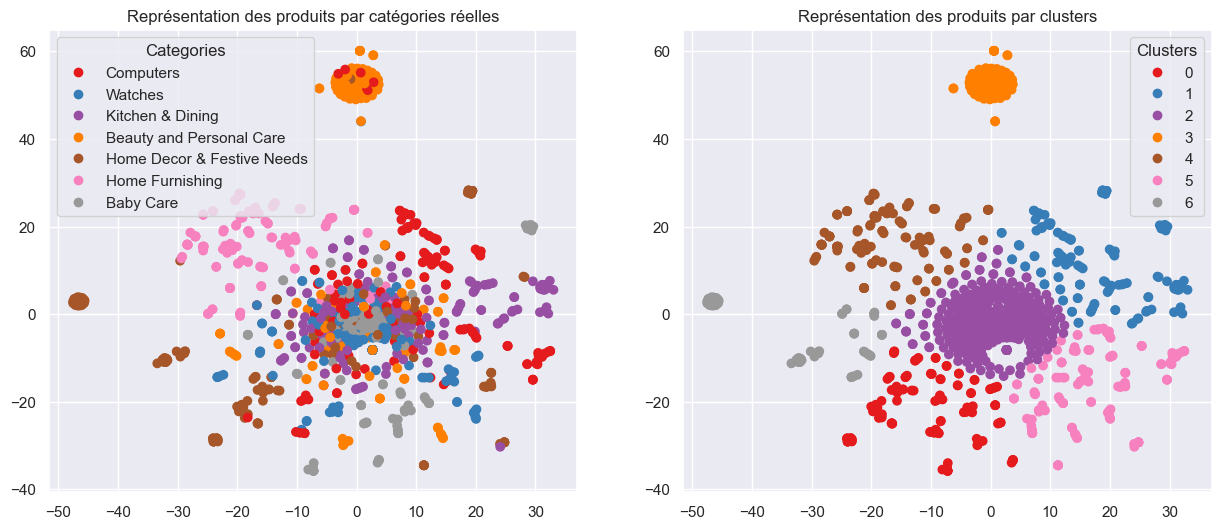

ARI :  0.2072


In [50]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [51]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

graph = tf.compat.v1.get_default_graph()

directory_path = '/path/to/directory'
tf.io.gfile.makedirs(directory_path)
print(f"Le répertoire {directory_path} a été créé avec succès.")


Le répertoire /path/to/directory a été créé avec succès.


In [52]:
!pip install --upgrade tensorflow

## Création du modèle Word2Vec

In [53]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 270 # adapt to length of sentences
sentences = df['description_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [54]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 3053
Word2Vec trained


In [55]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 3054


## Création de la matrice d'embedding

In [56]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3054, 300)


## Création du modèle d'embedding

In [57]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 270)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 270, 300)            │         916,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 916,200 (3.50 MB)

 Trainable params: 916,200 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

## Exécution du modèle

In [58]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


(1050, 300)

In [59]:
ARI, X_tsne, labels = ARI_fct(embeddings)

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.3852 time :  19.0


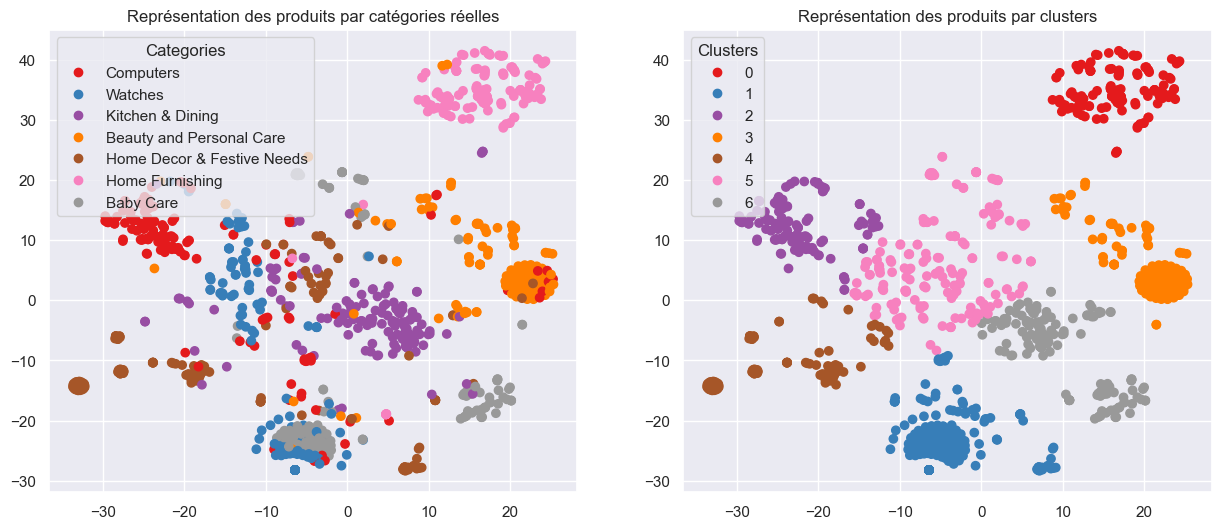

ARI :  0.3852


In [60]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [61]:
!pip install tf-keras

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [62]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.16.1
2.16.1
Num GPUs Available:  0
False


## Fonctions communes

In [63]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [64]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['description_dl'].to_list()

loading configuration file config.json from cache at C:\Users\tykap\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\tykap\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a6

Loaded 109,482,240 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on

In [65]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\tykap\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\tykap\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\vocab.t


1/1 [==============================] - 1s 1s/step
temps traitement :  167.0


In [66]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.3381 time :  26.0


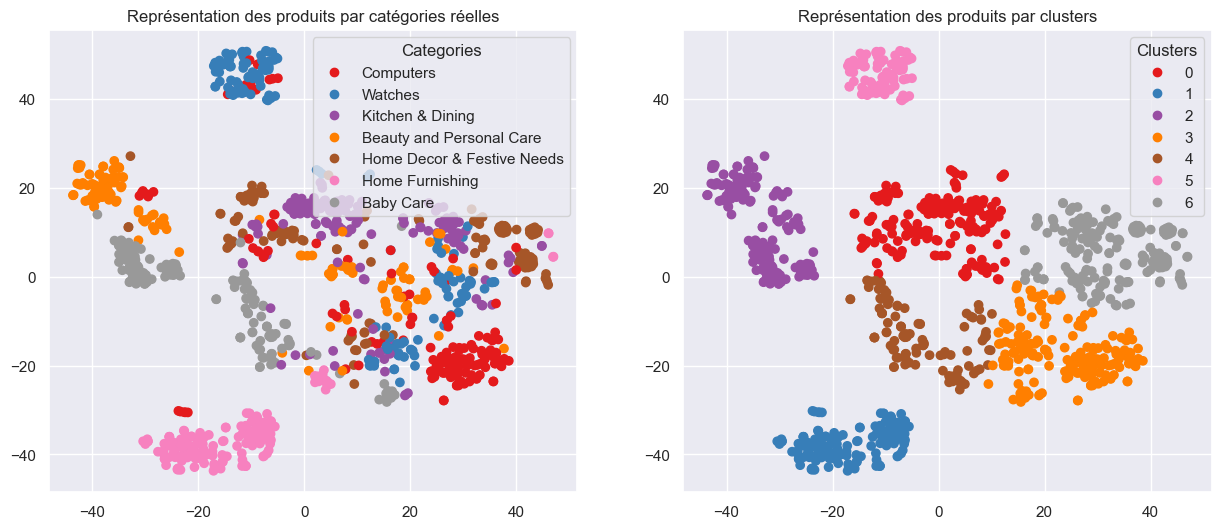

ARI :  0.3381


In [67]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [69]:
!pip install tensorflow_hub

import tensorflow_hub as hub
 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [70]:
sentences = df['description_dl'].to_list()

In [71]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\tykap\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\tykap\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\vocab.t

temps traitement :  125.0


In [72]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.3383 time :  27.0


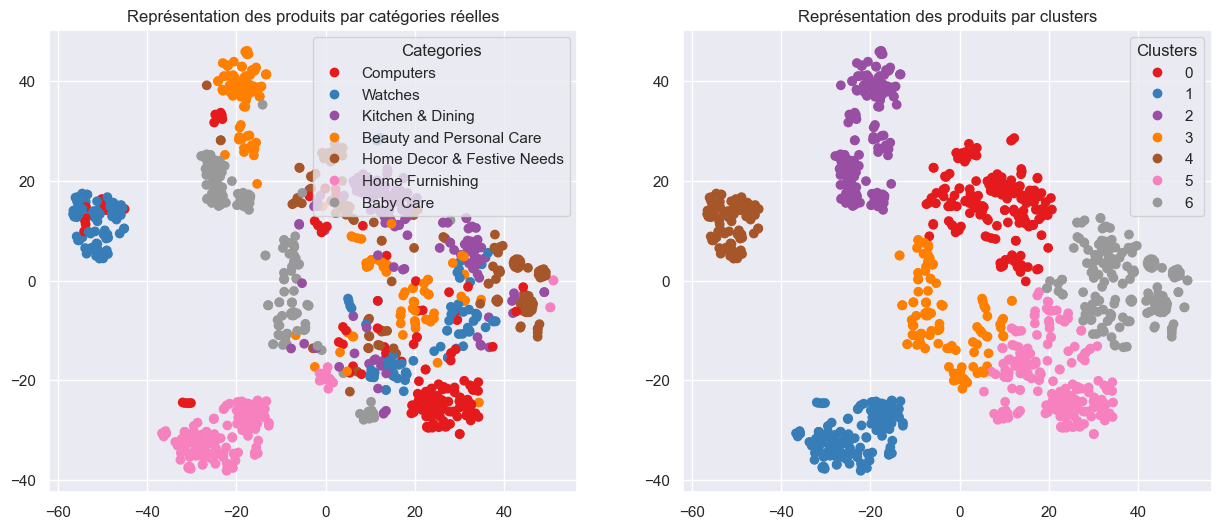

ARI :  0.3383


In [73]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [74]:
import tensorflow_hub as hub

embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

In [75]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [76]:
batch_size = 10
sentences = df['description_dl'].to_list()

In [77]:
features_USE = feature_USE_fct(sentences, batch_size)

In [78]:
ARI, X_tsne, labels = ARI_fct(features_USE)

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4432 time :  26.0


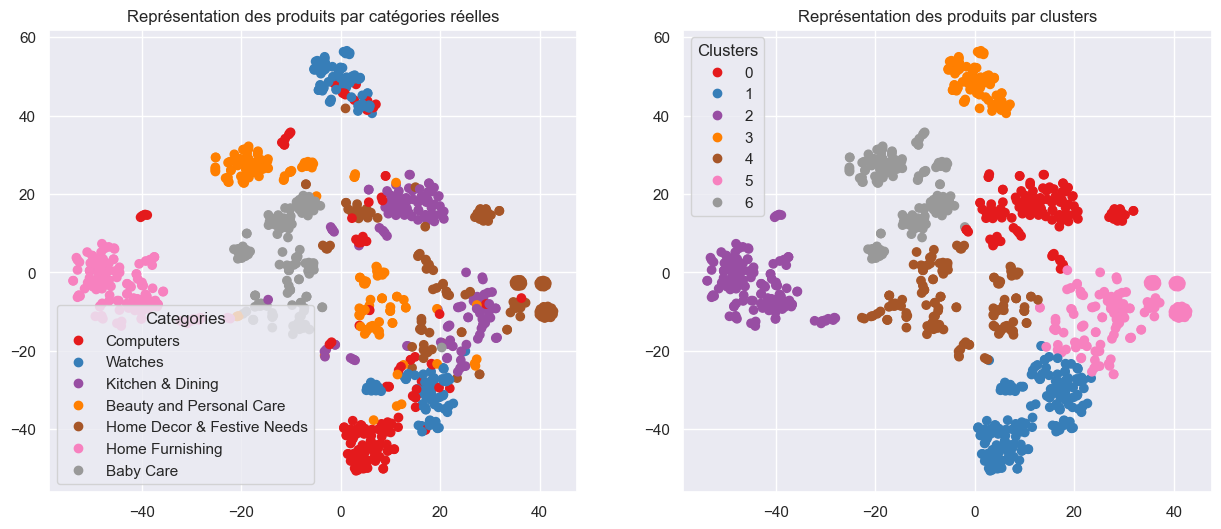

ARI :  0.4432


In [79]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Faisabilité de classification des images

In [80]:
from tensorflow.keras.utils import to_categorical
from PIL import ImageFilter

from os import listdir

path = "C:\\Users\\tykap\\OneDrive\\Bureau\\Formation Data\\OpenClarooms\\P6\\Images"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


## Création des labels des photos à partir du nom des images

In [81]:
data = df.copy()
data = data.drop(columns=["description","description_bow","description_bow_lem","description_dl","length_bow","lenght_bow_lem","length_dl"],axis=1).reset_index()
data = data.rename(columns = {'image':'image_path','product_category':'label_name'})

In [82]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])
data

uniq_id                            image_path  \
0     55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8  d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                ...                                   ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44  f2f027ad6a6df617c9f125173da71e44.jpg   

           label_name  label  
0     Home Furnishing      4  
1           Baby Care      0  
2           Baby Care      0  
3     Home Furnishing      4  
4     Home Furnishing      4  
...               ...    ...  
1045        Baby Care      0  
1046        Baby Care      0  
1047        Baby Care      0  
1048        Baby Care      0  
1049        Baby Care      0  

[1050 rows x 4 columns]

In [83]:
data[data.image_path == "009099b1f6e1e8f893ec29a7023153c4.jpg"]

uniq_id                            image_path  \
280  009099b1f6e1e8f893ec29a7023153c4  009099b1f6e1e8f893ec29a7023153c4.jpg   

    label_name  label  
280    Watches      6

In [84]:
data.groupby("label").count()

uniq_id  image_path  label_name
label                                 
0          150         150         150
1          150         150         150
2          150         150         150
3          150         150         150
4          150         150         150
5          150         150         150
6          150         150         150

## Affichage d'exemples d'images par label

Home Furnishing


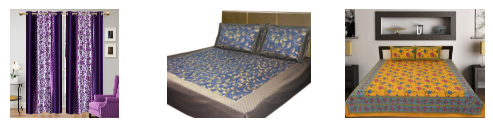

Baby Care


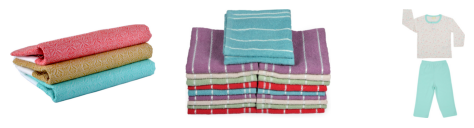

Watches


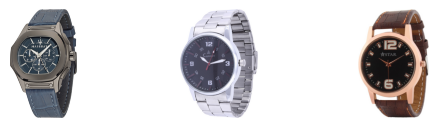

Home Decor & Festive Needs


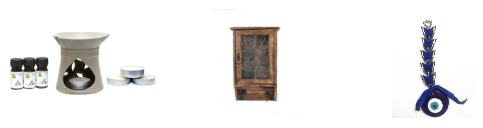

Kitchen & Dining


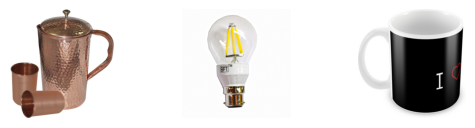

Beauty and Personal Care


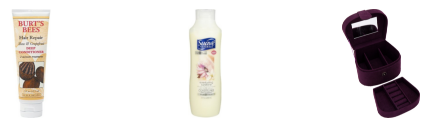

Computers


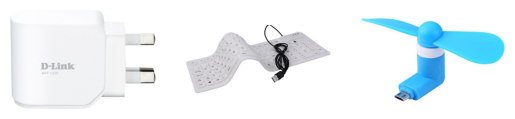

In [85]:
from matplotlib.image import imread

list_labels = ["Home Furnishing", "Baby Care", "Watches", "Home Decor & Festive Needs", "Kitchen & Dining", "Beauty and Personal Care", "Computers"]

for name in list_labels :
    print(name)
    list_generic = list(data[data['label_name'] == name]["image_path"])
    for i in range(3):
        plt.subplot(3, 3, 1+i)
        filename = r'C:\Users\tykap\OneDrive\Bureau\Formation Data\OpenClarooms\P6\Images\\'+list_generic[i]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

## Détermination et affichage des descripteurs SIFT

- L'image contient 198 descripteurs
- Chaque descripteur est un vecteur de longueur 128

Nombre de points clés détectés : 198


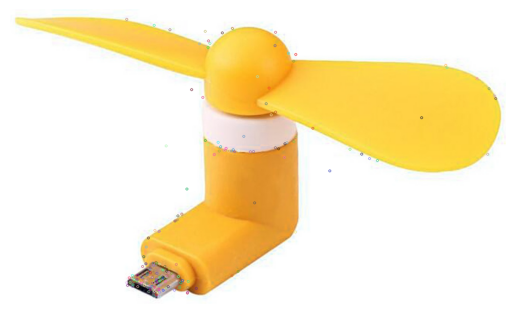

Descripteurs :  (198, 128)
[[  2. 151. 108. ...   0.   0.   0.]
 [ 46.   4.   1. ...   0.   0.   3.]
 [ 84. 102.   1. ...   0.   1.   2.]
 ...
 [  2.   9.   8. ...   0.   1.   8.]
 [ 11.   5.   2. ...   0.   1.  11.]
 [  3.   3.   1. ...   0.   0.   5.]]


In [86]:
! pip install opencv-python

import cv2

# Charger l'image
image = cv2.imread(filename,1)

# Vérifiez si l'image est chargée correctement
if image is None:
    raise ValueError(f"L'image à {image_path} n'a pas pu être chargée. Veuillez vérifier le chemin.")

# Convertir l'image en niveaux de gris
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Vérifiez la profondeur de pixel
if gray_image.dtype != 'uint8':
    raise ValueError("L'image doit être de type uint8 (CV_8U)")

# Initialiser SIFT
sift = cv2.SIFT_create()

# Détecter et calculer les descripteurs
kp, des = sift.detectAndCompute(gray_image, None)

# Vérifiez si des keypoints ont été détectés
if kp is None or des is None:
    raise ValueError("Aucun point clé ou descripteur n'a été détecté.")

print(f"Nombre de points clés détectés : {len(kp)}")

img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.axis('off')
plt.show()
print("Descripteurs : ", des.shape)
print(des)

In [87]:
print("OpenCV version:", cv2.__version__)

OpenCV version: 4.10.0


# Pré-traitement des images via SIFT

## Exemples de traitements d'images

55b85ea15a1536d46b7190ad6fff8ce7.jpg


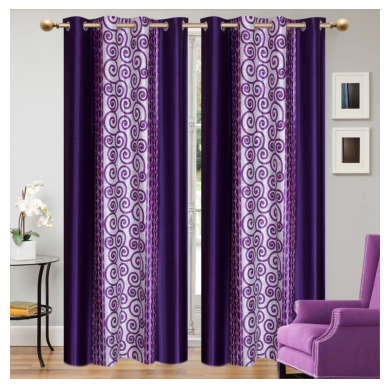

In [88]:
path = "C:\\Users\\tykap\\OneDrive\\Bureau\\Formation Data\\OpenClarooms\\P6\\Images\\"
print(data.image_path.head()[0])
filename = path + data.image_path.head()[0]
image = imread(filename)
plt.imshow(image)
plt.axis('off')
plt.show()

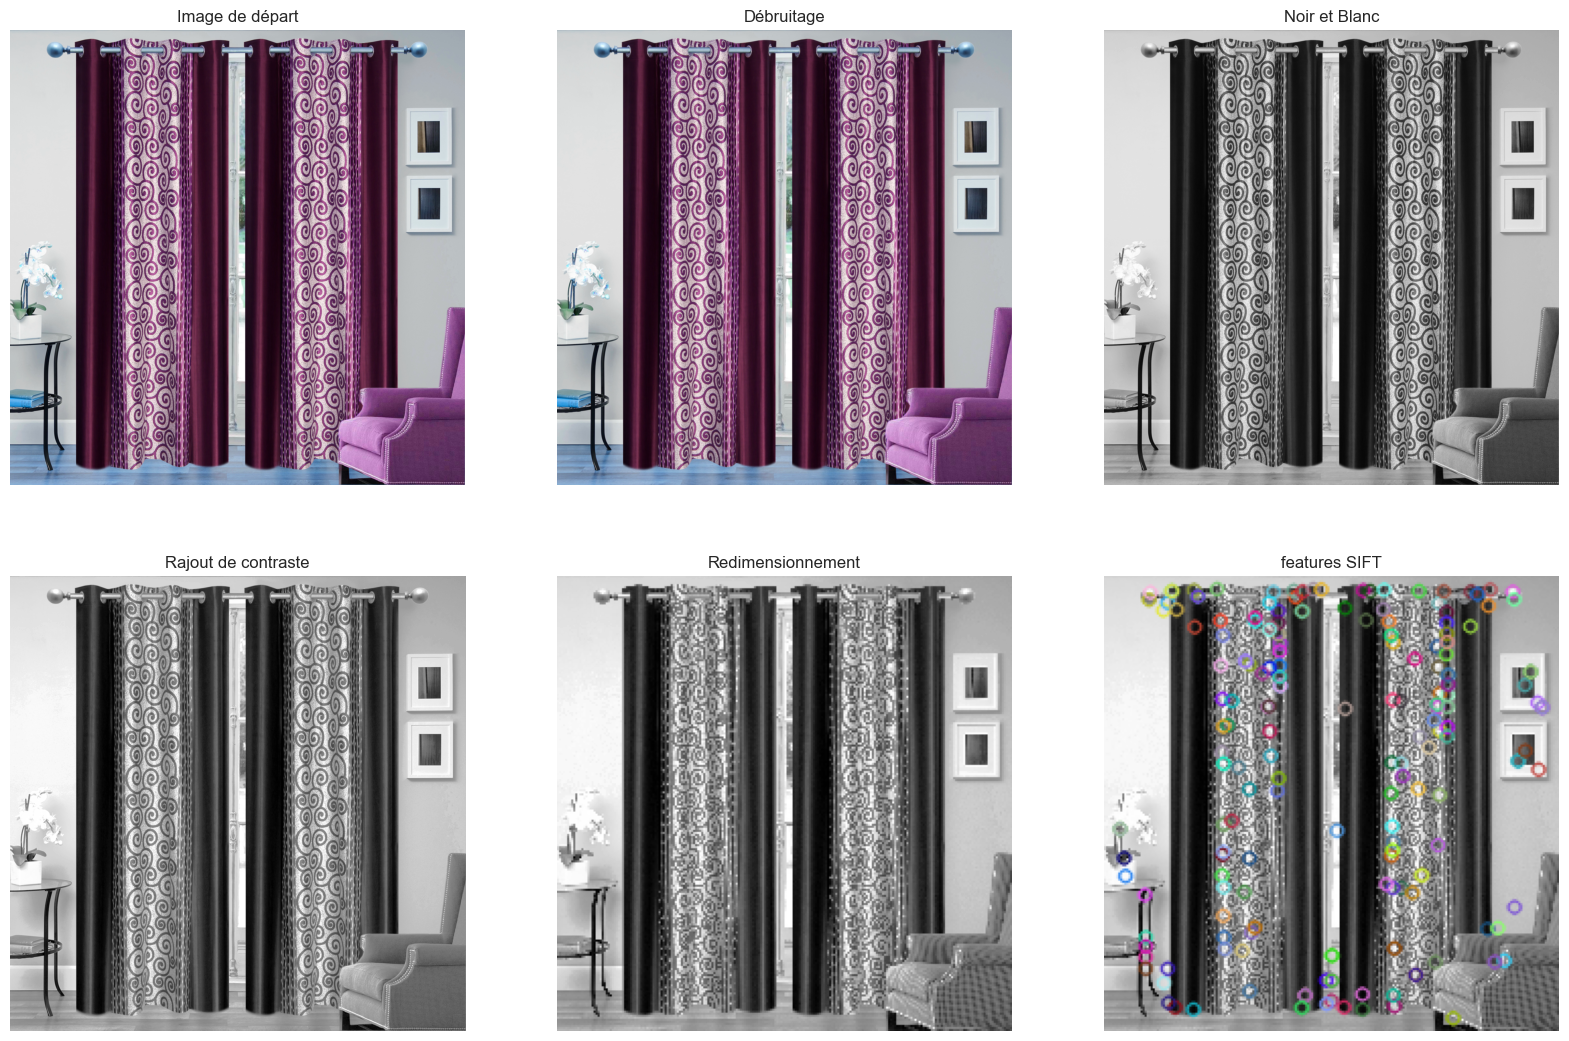

In [89]:
sift = cv2.SIFT_create(200)
image = cv2.imread(filename)

plt.figure(figsize=(20, 13))

plt.subplot(2,3,1)
plt.axis('off')
plt.title('Image de départ')
plt.imshow(image)

plt.subplot(2,3,2)
#on enleve le bruit
image = cv2.GaussianBlur(image, (5, 5), 0)
plt.axis('off')
plt.title('Débruitage')
plt.imshow(image)

#on passe en noir et blanc
plt.subplot(2,3,3)
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.axis('off')
plt.title('Noir et Blanc')
plt.imshow(gray_img,cmap='gray')

#augmentation du contraste par égalisation du contraste
plt.subplot(2,3,4)
image = cv2.equalizeHist(gray_img)   # equalize image histogram
plt.axis('off')
plt.title('Rajout de contraste')
plt.imshow(image, cmap='gray')

#on redimensionne pour normaliser entrée
plt.subplot(2,3,5)
dsize = (224, 224)
image = cv2.resize(image, dsize)
plt.axis('off')
plt.title('Redimensionnement')
plt.imshow(image, cmap='gray')

#detecion feature SIFT
plt.subplot(2,3,6)
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,gray_img)
plt.axis('off')
plt.title('features SIFT')
plt.imshow(img)

plt.savefig('RetraitementImages.jpg')
plt.show()

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [90]:
# identification des points clés et descripteurs associés

import time, glob

# Répertoire contenant les images
image_directory = r'C:\Users\tykap\OneDrive\Bureau\Formation Data\OpenClarooms\P6\Images\\'

# Extension des fichiers d'images (par exemple, .jpg, .png, etc.)
image_extension = '*.jpg'  # Changez l'extension selon vos fichiers d'image

# Obtenir la liste de tous les fichiers d'images dans le répertoire
filenames = glob.glob(os.path.join(image_directory, image_extension))

sift_keypoints = []
temps1 = time.time()

# Initialiser SIFT
sift = cv2.SIFT_create(500)

for img in filenames:
    
    # Charger l'image
    image = cv2.imread(img)
    
    # Vérifiez si l'image est chargée correctement
    if image is None:
        print(f"Erreur lors du chargement de l'image : {img}")
        continue
    
    # Vérifiez le type de l'image
    if not isinstance(image, np.ndarray):
        print(f"L'image chargée n'est pas un tableau NumPy : {img}")
        continue
    
    # Convertir l'image en niveaux de gris
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Equalize image histogram
    res = cv2.equalizeHist(gray_image)
    
    # Détecter et calculer les descripteurs
    kp, des = sift.detectAndCompute(res, None)
    
    # Ajouter les descripteurs à la liste
    if des is not None:
        sift_keypoints.append(des)

# Convertir en tableau NumPy
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)

# Vérifiez s'il y a des descripteurs à concaténer
if len(sift_keypoints) > 0:
    sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
    print("Nombre de descripteurs : ", sift_keypoints_all.shape)
else:
    print("Aucun descripteur trouvé.")

duration1 = time.time() - temps1
print("Temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

Nombre de descripteurs :  (517306, 128)
Temps de traitement SIFT descriptor :          1934.25 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [91]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans :            27.02 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [92]:
# Creation des histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, img):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", img)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation d'une matrix des histogrammes
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) # construction de l'histogramme
    hist_vectors.append(hist) # l'histogramme est le ecteur caractéristique

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :           162.78 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [93]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 494)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [94]:
tsne = manifold.TSNE(n_components=2, perplexity=20, learning_rate=400,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

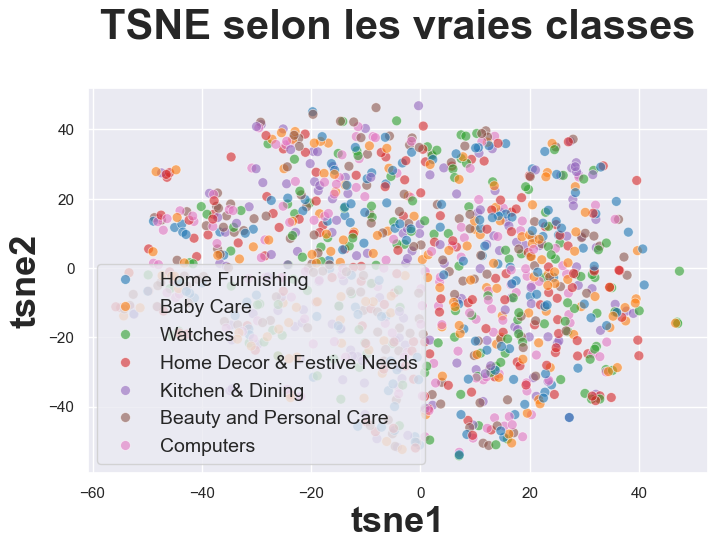

In [95]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [96]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

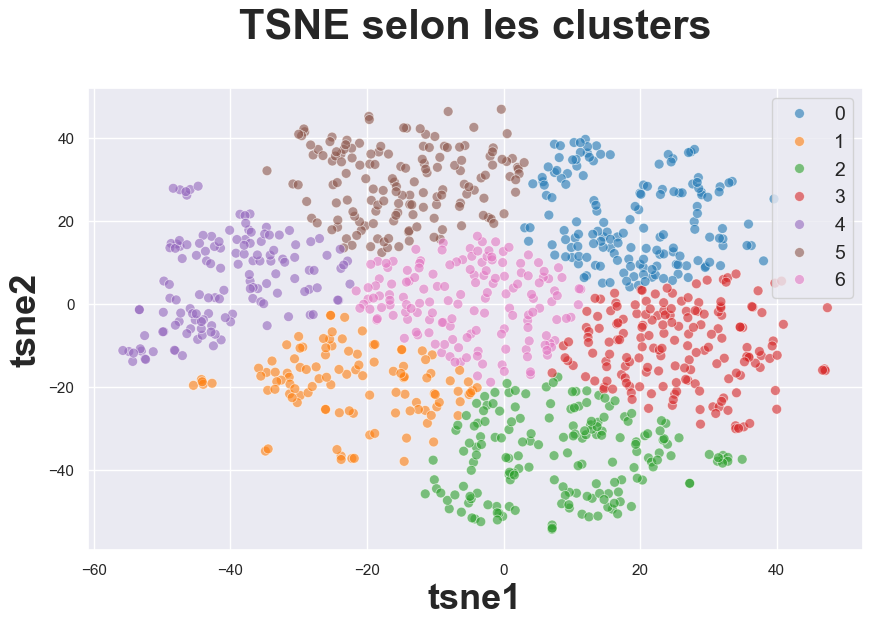

ARI :  0.003190831833707807


In [97]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Visuellement, la séparation entre les différents clusters n’est pas nette. Le très faible score ARI vient confirmer cette observation visuelle. En s’appuyant uniquement sur cette méthode d’embedding via les descripteurs SIFT, la faisabilité d’une classification des produits en fonction de leurs images n’est pas admise.

 ## Faisabilité classification automatique des images via VGG16

In [98]:
# example of using the vgg16 model as a feature extraction model

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras import Input
from keras import Model

# load model
model = VGG16()

# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# identification of key points and associated descriptors
import time, cv2

path = "C:\\Users\\tykap\\OneDrive\\Bureau\\Formation Data\\OpenClarooms\\P6\\Images\\"
list_photos =  data['image_path'].values.tolist()

vgg_keypoints = []

temps1=time.time()

for image_num in range(len(list_photos)) :
    if image_num%200 == 0 : print(image_num)
    # load an image from file
    image = load_img(path+list_photos[image_num], target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    #reduction bruit
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    features = model.predict(image)
    vgg_keypoints.append(features)

vgg_keypoints_by_img = np.asarray(vgg_keypoints)
vgg_keypoints_all    = np.concatenate(vgg_keypoints_by_img, axis=0)

print()
print("Longueur embedding VGG16 : ", vgg_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement VGG embedding : ", "%15.2f" % duration1, "secondes")

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## Réductions de dimension

### Réduction de dimension PCA

In [100]:
from sklearn import manifold, decomposition

print("Dimensions avant réduction PCA : ", vgg_keypoints_all.shape)
pca_vgg = decomposition.PCA(n_components=0.99)
feat_pca_vgg= pca_vgg.fit_transform(vgg_keypoints_all)
print("Dimensions après réduction PCA : ", feat_pca_vgg.shape)

Dimensions avant réduction PCA :  (1050, 4096)
Dimensions après réduction PCA :  (1050, 793)


In [101]:
from sklearn.cluster import KMeans

km_vgg = KMeans(n_clusters=7)
km_vgg.fit(vgg_keypoints_all)

km_vgg_acp = KMeans(n_clusters=7)
km_vgg_acp.fit(feat_pca_vgg)

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a mem

KMeans(n_clusters=7)

In [102]:
from sklearn.metrics.cluster import adjusted_rand_score

ari = adjusted_rand_score(data['label_name'], km_vgg.labels_)
ari_acp = adjusted_rand_score(data['label_name'], km_vgg_acp.labels_)

print(f'ARI     : {ari:.3f}')
print(f'ARI ACP : {ari_acp:.3f}')

ARI     : 0.452
ARI ACP : 0.442


### Réduction de dimension T-SNE

In [103]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=20, 
                     n_iter=2000, init='random', random_state=142)

X_tsne_sift = tsne.fit_transform(vgg_keypoints_all)
df_tsne_sift = pd.DataFrame(X_tsne_sift, columns=['tsne1', 'tsne2'])
print(X_tsne_sift.shape)

(1050, 2)


## Analyse visuelle : affichage T-SNE selon catégories d'images

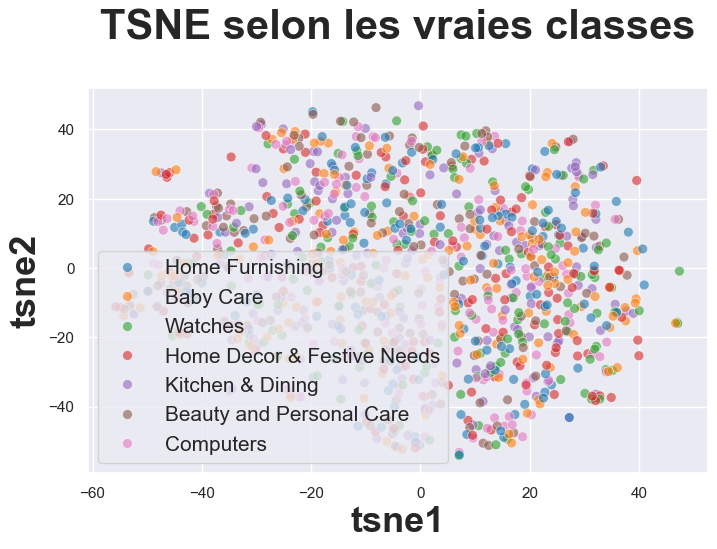

In [104]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 15}) 

plt.show()

### Analyse mesures : similarité entre catégories et clusters

In [105]:
cls = cluster.KMeans(n_clusters=7, random_state=142)
cls.fit(X_tsne_sift)

df_tsne_sift["cluster"] = cls.labels_
print(df_tsne_sift.shape)

C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 3)


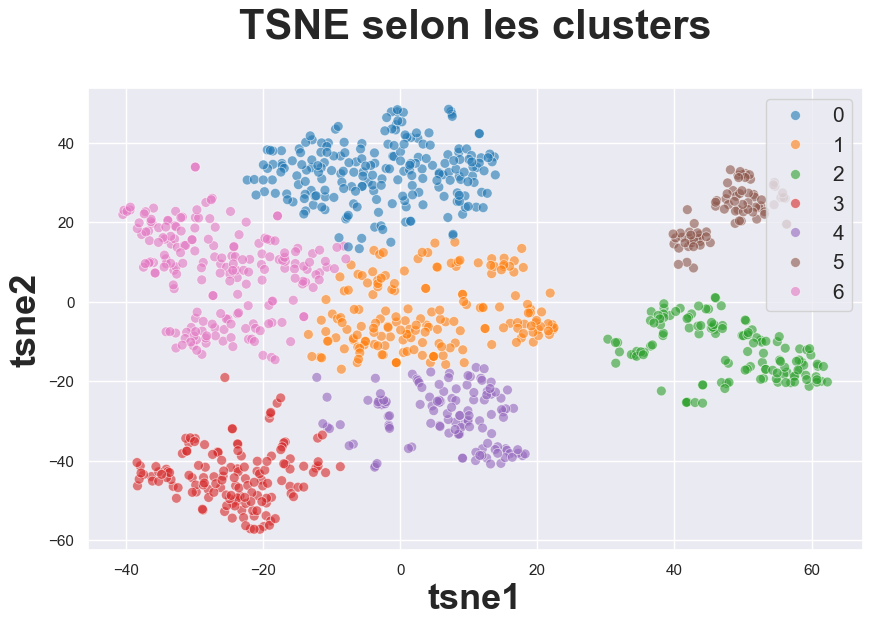

ARI :  0.4609506189486312


In [106]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_sift,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 15}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data